# **Modul 6 AI LLM**

---

**Nama**: Michael Kenneth Salim <br>
**NRP**: 5027231008

## **Import Library**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re
import string

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction


from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from huggingface_hub import login

In [23]:
login()

## **EDA**

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.head(5)

,text,amusement,anger,annoyance,caring,confusion,disappointment,disgust,embarrassment,excitement,fear,gratitude,joy,love,sadness
0,And if they can't find US suckers to give them...,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,Definitely teased you ;) I think it was punish...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Probably nothing. I'm assuming they're disputi...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,"Regardless, fight 'em every inch of the way li...",0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Define woman please if you're not going to use...,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head(5)

,id,text
0,oupyc,Now I can’t unhear it...
1,eylly,I post on the the Donald you think I give a fa...
2,bnmji,"Unlikely, but who knows? Memory speed rarely m..."
3,zmker,Is it possible you've been banned from them? I...
4,36lqo,You're in for a treat- enjoy :)


In [7]:
df_train.isnull().sum()

,0
text,0
amusement,0
anger,0
annoyance,0
caring,0
confusion,0
disappointment,0
disgust,0
embarrassment,0
excitement,0


In [8]:
df_test.isnull().sum()

,0
id,0
text,0


### **Visualisasi**

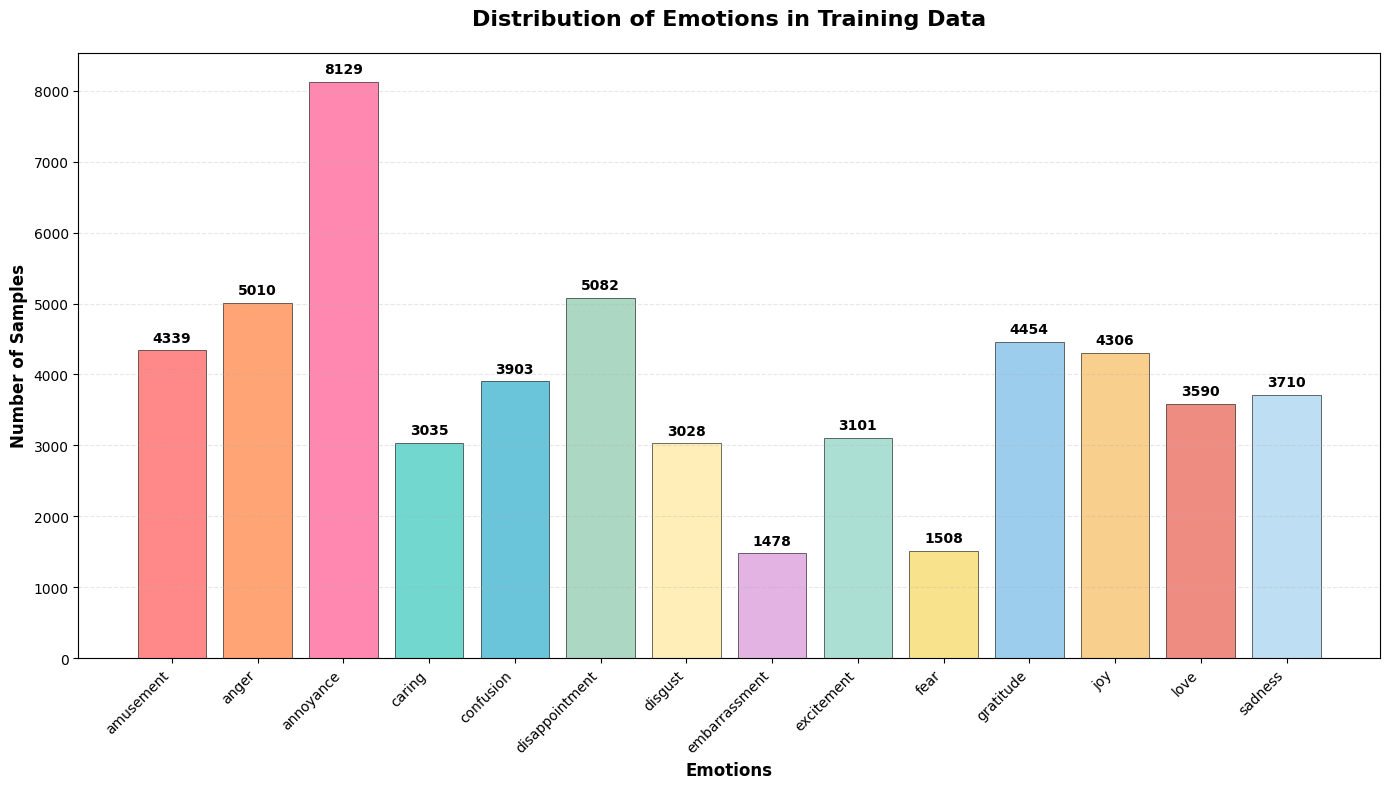

In [9]:
emotion_columns = ['amusement', 'anger', 'annoyance', 'caring', 'confusion',
                   'disappointment', 'disgust', 'embarrassment', 'excitement',
                   'fear', 'gratitude', 'joy', 'love', 'sadness']

emotion_counts = df_train[emotion_columns].sum()

plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#FF8E53', '#FF6B9D', '#4ECDC4', '#45B7D1',
          '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F',
          '#85C1E9', '#F8C471', '#EC7063', '#AED6F1']

bars = plt.bar(range(len(emotion_counts)), emotion_counts.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Emotions', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Emotions in Training Data', fontsize=16, fontweight='bold', pad=20)

plt.xticks(range(len(emotion_counts)), emotion_counts.index, rotation=45, ha='right')

for i, (emotion, count) in enumerate(zip(emotion_counts.index, emotion_counts.values)):
    plt.text(i, count + max(emotion_counts.values) * 0.01, str(count),
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## **Data Pre-Processing**

In [10]:
def prepare_labels(row):
    return [row[label] for label in emotion_columns]

df_train['labels'] = df_train.apply(prepare_labels, axis=1)

In [11]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

In [13]:
df_train[['text', 'cleaned_text']][:15]

,text,cleaned_text
0,And if they can't find US suckers to give them...,And if they cant find US suckers to give them ...
1,Definitely teased you ;) I think it was punish...,Definitely teased you I think it was punishmen...
2,Probably nothing. I'm assuming they're disputi...,Probably nothing Im assuming theyre disputing ...
3,"Regardless, fight 'em every inch of the way li...",Regardless fight em every inch of the way like...
4,Define woman please if you're not going to use...,Define woman please if youre not going to use ...
5,at sunset i want to bang my wife there on the ...,at sunset i want to bang my wife there on the ...
6,Especially the Lexus peeps. Just baffles me ho...,Especially the Lexus peeps Just baffles me how...
7,I'm crying laughing in the cubes.,Im crying laughing in the cubes
8,OMG she's BYEsexual. Sorry I had to.,OMG shes BYEsexual Sorry I had to
9,"NSFW tagged for showing [NAME]. But anyways, I...",NSFW tagged for showing NAME But anyways I hop...


### Split

In [50]:
train_texts = df_train['text'].tolist()
train_labels = df_train['labels'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [51]:
train_data = Dataset.from_dict({
    'text': train_texts,
    'labels': train_labels
})

val_data = Dataset.from_dict({
    'text': val_texts,
    'labels': val_labels
})

### Inisiasi model

In [52]:
model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [53]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=128
    )

In [54]:
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/37164 [00:00<?, ? examples/s]

Map:   0%|          | 0/9291 [00:00<?, ? examples/s]

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotion_columns),
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
training_args = TrainingArguments(
    output_dir='./emotion_classifier',
    eval_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=True,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    report_to=[],
    hub_model_id="KenetHilang/emotion-classifier",
)

In [57]:
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels

    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'f1': f1_micro,
        'f1_macro': f1_macro,
    }

In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
)

In [60]:
print("Starting training...")
trainer.train()

Starting training...


ValueError: expected sequence of length 51 at dim 1 (got 50)

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

In [ ]:
trainer.save_model("./emotion_classifier_final")
tokenizer.save_pretrained("./emotion_classifier_final")

## **Upload Model to HuggingFace**

## **Generate Test Predictions for Kaggle**

In [ ]:
submission = pd.DataFrame(test_predictions, columns=emotion_columns)
submission.insert(0, 'id', df_test.index)

submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")
print(f"Shape: {submission.shape}")
print("\nFirst 5 rows:")
print(submission.head())

# Check submission format
print("\nSubmission statistics:")
print(submission[emotion_columns].describe())